Stitched image saved as 'stitched_result.jpg'


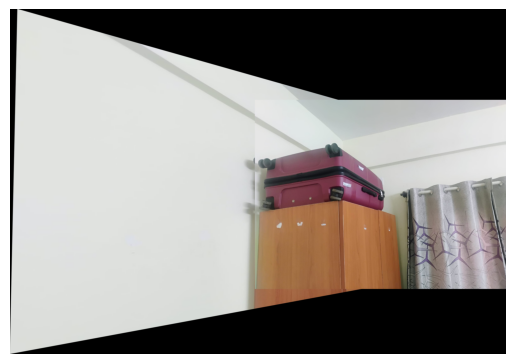

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images_sift(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    if descriptors1 is None or descriptors2 is None:
        print("Feature detection failed. Try different images or tuning SIFT parameters.")
        return None

    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda m: m.distance)  # Sort by match quality

    best_matches = matches[:50]

    source_pts = np.float32([keypoints1[m.queryIdx].pt for m in best_matches]).reshape(-1, 1, 2)
    dest_pts = np.float32([keypoints2[m.trainIdx].pt for m in best_matches]).reshape(-1, 1, 2)

    homography_matrix, status = cv2.findHomography(source_pts, dest_pts, cv2.RANSAC, 5.0)
    if homography_matrix is None:
        print("Homography calculation failed. Check if there are enough good matches.")
        return None

    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]

    corners_image1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners_image1, homography_matrix)

    all_corners = np.concatenate((transformed_corners, corners_image1), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation_offset = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation_offset[0]],
                                   [0, 1, translation_offset[1]],
                                   [0, 0, 1]], dtype=np.float32)

    stitched_width = x_max - x_min
    stitched_height = y_max - y_min
    result = cv2.warpPerspective(image1, translation_matrix.dot(homography_matrix), (stitched_width, stitched_height))

    result[translation_offset[1]:translation_offset[1]+height2,
           translation_offset[0]:translation_offset[0]+width2] = image2

    return result

def main():
    img1 = cv2.imread('/content/abh.jpg')
    img2 = cv2.imread('/content/eet.jpg')

    if img1 is None or img2 is None:
        print("Error: Could not read one or both images. Check file paths.")
        return

    stitched_image = stitch_images_sift(img1, img2)
    if stitched_image is not None:
        cv2.imwrite('stitched_result.jpg', stitched_image)
        print("Stitched image saved as 'stitched_result.jpg'")

        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Image stitching failed.")

if __name__ == "__main__":
    main()
